In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
import sys
sys.path.append('./modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *

In [3]:
def yolov7_format_to_bbox_format(x_center, y_center, width, height):
    x0 = x_center - width / 2.0
    y0 = y_center - height / 2.0

    x1 = x_center + width / 2.0
    y1 = y_center + height / 2.0

    return x0, y0, x1, y1

In [32]:
def read_format_table(path, read_gt = False):
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    if read_gt:
        cols = ['class', 'x_center', 'y_center', 'width', 'height']
    else:
        cols = ['class', 'x_center', 'y_center', 'width', 'height', 'confidence']
    df = pd.read_csv(path, delimiter=' ', header=None, names=cols)
    df = df.sort_values('class').reset_index(drop=True)
    df['x_center'] = (df['x_center'] * IMG_WIDTH).round().astype(int)
    df['y_center'] = (df['y_center'] * IMG_HEIGHT).round().astype(int)
    df['width'] = (df['width'] * IMG_WIDTH).round().astype(int)
    df['height'] = (df['height'] * IMG_HEIGHT).round().astype(int)

    return df
def extract_box_np_from_df(df, label):
    row = df.loc[df['class'] == label]
    if len(row) > 1:
        row = row[row['confidence'] == row['confidence'].max()]
    print(row)
    box = np.array(yolov7_format_to_bbox_format(row['x_center'].item(), 
                                      row['y_center'].item(),
                                      row['width'].item(), 
                                      row['height'].item()))
    return box

In [8]:
read_format_table('/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/dir_structure_for_yolov7/val/labels/114217_slice82.txt', read_gt=True)

,class,x_center,y_center,width,height
0,0,128,128,255,255
1,1,116,136,8,6
2,20,122,117,23,8
3,55,121,132,26,6
4,60,116,137,12,14
5,62,128,135,19,12
6,63,104,134,8,5
7,67,104,140,13,11
8,86,128,120,24,10
9,91,120,115,13,12


In [17]:
Image.open(os.path.join('/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/dir_structure_for_yolov7/val/images/114217_slice200.png'))

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/dir_structure_for_yolov7/val/images/114217_slice200.png'

In [51]:
slice_num=124
img_id = 102109
label = 59
xx = np.load(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox/{img_id}/{slice_num}.npy')[label,:]
print(xx)


[nan nan nan nan]


found at slice 146
    class  x_center  y_center  width  height  confidence
10     12       116       128      9      17    0.744629
    class  x_center  y_center  width  height
10     12       116       128      9      18
[113. 119. 119. 134.]


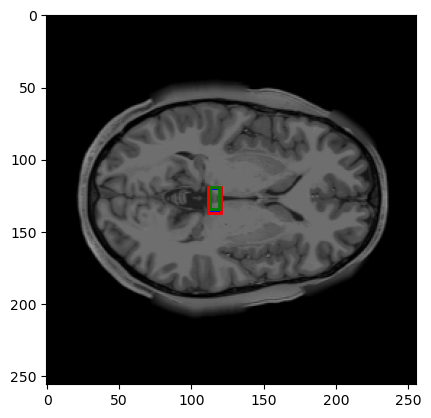

In [72]:
label = 12
img_id = 102109
#img_name = '100206_slice128'
for slice_num in range(256):
    slice_num = 146
    img_name = f'{img_id}_slice{slice_num}'
    img_path = os.path.join('/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/dir_structure_for_yolov7/val/images', img_name+'.png')
    gt_path = os.path.join('/gpfs/data/luilab/karthik/pediatric_seg_proj/hcp_ya_slices_npy/dir_structure_for_yolov7/val/labels', img_name+'.txt')
    gt_table = read_format_table(gt_path, read_gt=True)
    if label not in gt_table['class'].tolist():
        continue
    print(f'found at slice {slice_num}')
    df = read_format_table(f'/gpfs/home/kn2347/yolov7/train_hcp_bbox/val4/labels/{img_name}.txt', read_gt=False)


    row = df.loc[df['class'] == label]
    
    if len(row) == 0:
        print('missed example')
        continue


    box = extract_box_np_from_df(df, label)

    gt_box = extract_box_np_from_df(gt_table, label)

    img = np.asarray(Image.open(img_path))
    plt.imshow(img)
    show_box(box, plt.gca())
    show_box(gt_box, plt.gca(), 'red')

    # MedSAM-generated bounding box
    medsam_bbox_path = os.path.join('/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round1_segmentations_bbox', str(img_id), f'{slice_num}.npy')
    medsam_bbox = np.load(medsam_bbox_path)[label,:][[0,2,1,3]]
    print(medsam_bbox) # this is now xmin, ymin, xmax, ymax
    show_box(medsam_bbox, plt.gca(), 'green')

    break

